# Generate the figures

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load the data

In [2]:
# Define the data and figure folder.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"
h_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/h/"

In [3]:
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

In [4]:
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]
mdata.uns = {}

## Plot the embedding

In [5]:
joint_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)
joint_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

In [6]:
sc.pp.neighbors(joint_embedding, n_neighbors=25)
sc.tl.umap(joint_embedding)

In [7]:
sc.tl.leiden(joint_embedding, resolution=.2, key_added="leiden")
sc.tl.leiden(joint_embedding, resolution=3, key_added="leiden_precise")

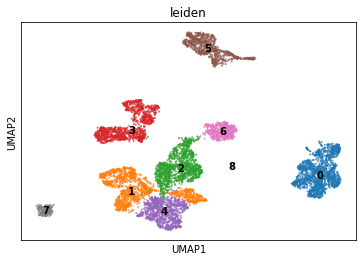

In [8]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, legend_loc="on data", save="tea_leiden.pdf")

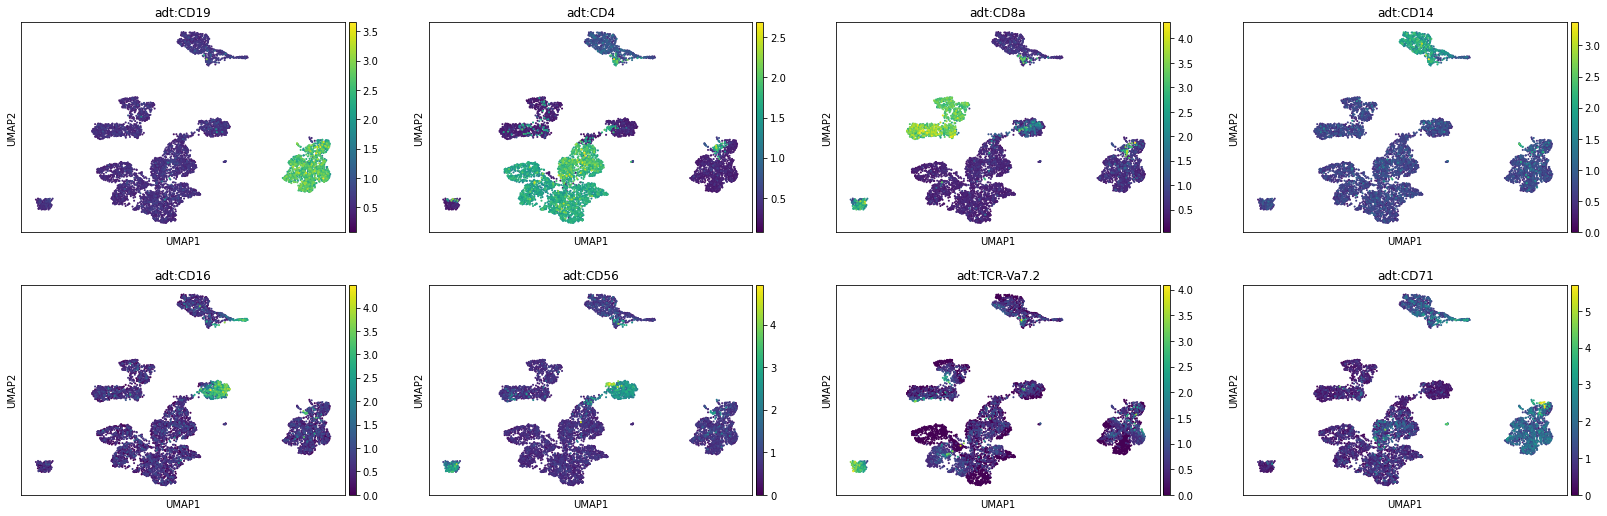

In [9]:
sc.pl.umap(
    joint_embedding,
    color=[
        "adt:CD19", # B cells
        "adt:CD4", # CD4 T cells
        "adt:CD8a", # CD8 T cells
        "adt:CD14", # Monocytes
        "adt:CD16", # Monocytes
        "adt:CD56", # NK cells
        "adt:TCR-Va7.2", # MAIT T cells
        "adt:CD71", # Erythroid cells
    ],
)

In [10]:
cluster_names = {
    0: "B cells",
    1: "CD4 T cells",
    2: "CD4 T cells",
    3: "CD8 T cells",
    4: "CD4 T cells",
    5: "Monocytes",
    6: "NK cells",
    7: "MAIT T cells",
    8: "Erythroid cells",
}
joint_embedding.obs["leiden"] = [cluster_names[c] for c in joint_embedding.obs["leiden"].cat.codes]

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


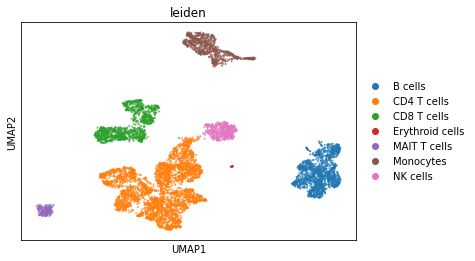

In [11]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, save="tea_leiden.pdf")

In [12]:
sc.tl.dendrogram(joint_embedding, groupby="leiden_precise")
joint_embedding.obs["leiden_precise"] = joint_embedding.obs["leiden_precise"].cat.rename_categories(np.argsort(joint_embedding.uns["dendrogram_leiden_precise"]["categories_idx_ordered"]))
joint_embedding = joint_embedding[joint_embedding.obs["leiden_precise"].argsort()]

Trying to set attribute `.uns` of view, copying.


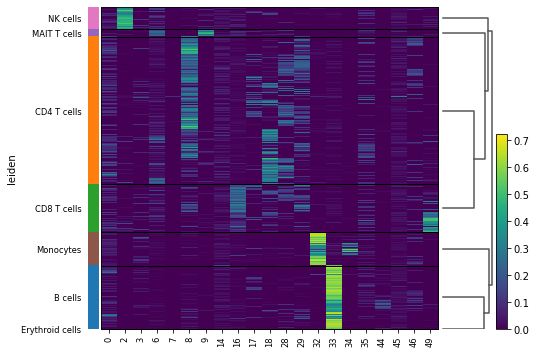

In [13]:
sc.tl.dendrogram(joint_embedding, groupby="leiden")
sc.pl.heatmap(
    joint_embedding,
    var_names=joint_embedding.var_names[joint_embedding.X.max(0) > 0.3],
    groupby="leiden",
    dendrogram=True
)


## Analyse the dimensions using proteins

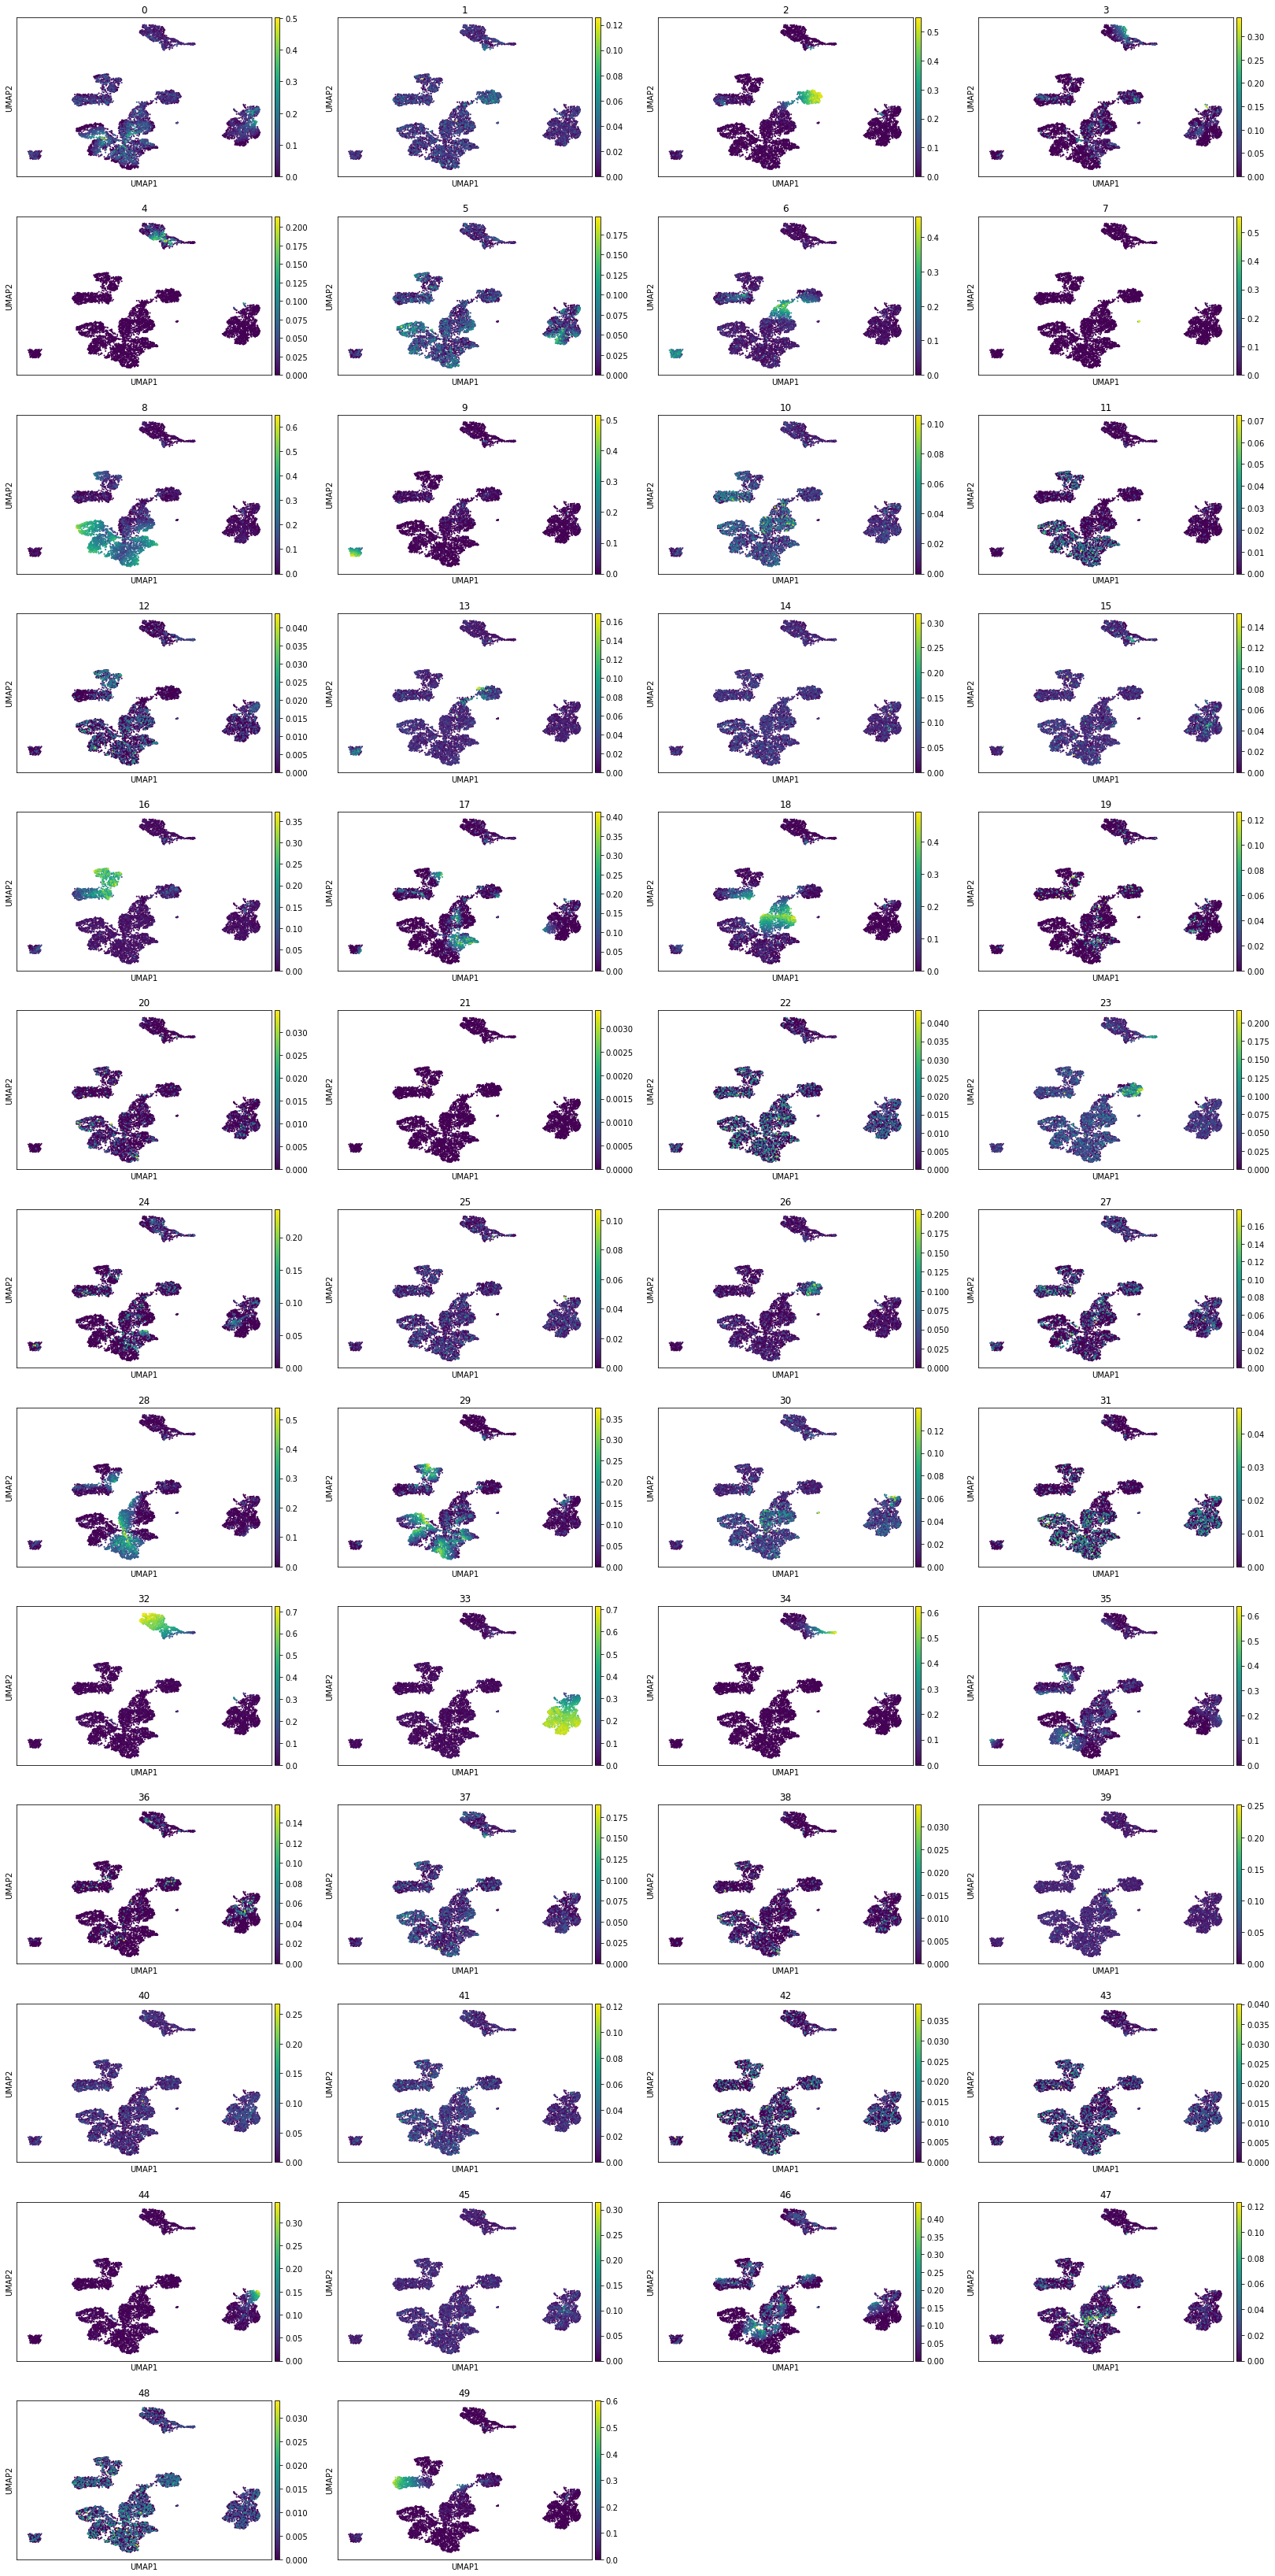

In [16]:
sc.pl.umap(
    joint_embedding,
    color=[
        "0", # ?
        "1", # ?
        "2", # NK dim: CD56dim, CD16+, KLRG1+
        "3", # ?
        "4", # Intermediate monocytes
        "5", # ?
        "6", # Some CD4 + MAIT: KLRG1
        "7", # Erythrocytes: CD71
        "8", # CD4 naive: with CD45RA
        "9", # MAIT: CD8+, TCRalpha7.2
        "10", # ?
        "11", # ?
        "12", # ?
        "13", # NK bright: CD56bright
        "14", # ?
        "15", # ?
        "16", # CD8 T cells
        "17", # ?
        "18", # Some CD4 + some CD8: memory?
        "19", # ?
        "20", # ?
        "21", # ?
        "22", # ?
        "23", # Some monocytes + NK
        "24", # ?
        "25", # ?
        "26", # some NK
        "27", # ?
        "28", # ?
        "29", # ?
        "30", # ?
        "31", # ?
        "32", # Classical monocytes: CD14+
        "33", # B cells
        "34", # Non-classical monocytes: CD16+
        "35", # ?
        "36", # ?
        "37", # ?
        "38", # ?
        "39", # ?
        "40", # ?
        "41", # ?
        "42", # ?
        "43", # ?
        "44", # Some B cells
        "45", # ?
        "46", # ?
        "47", # ?
        "48", # ?
        "49", # Some CD8+
    ],
)


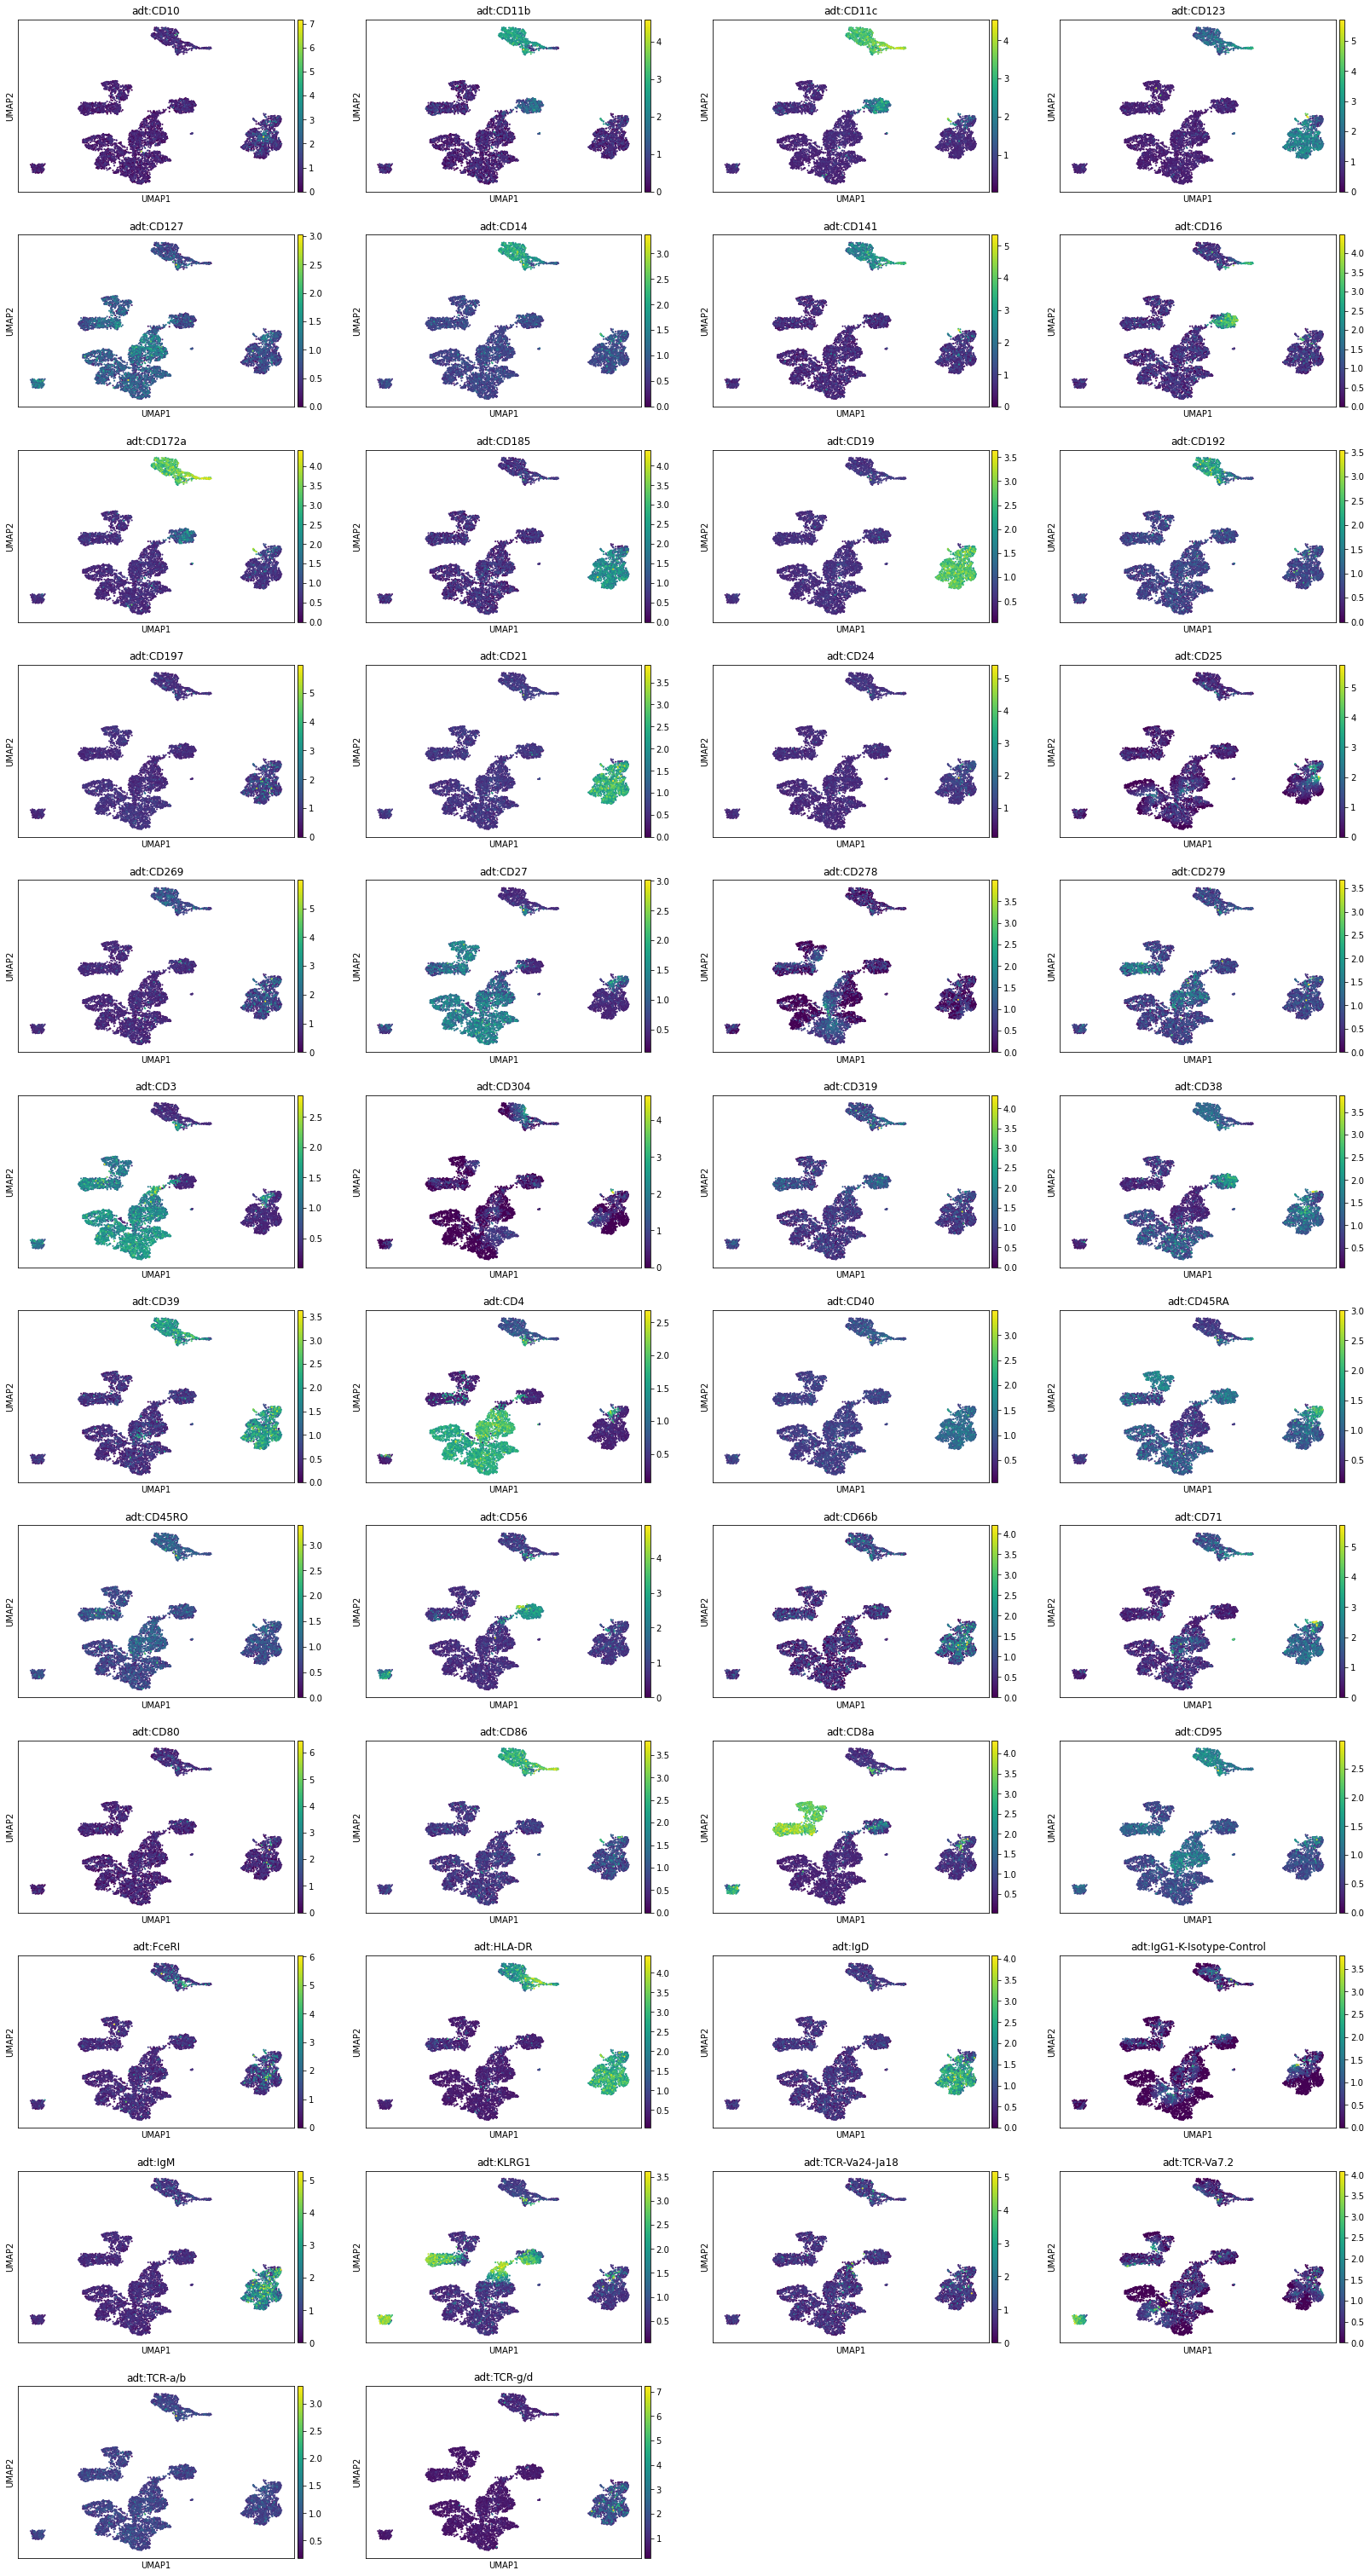

In [15]:
sc.pl.umap(
    joint_embedding,
    color=mdata["adt"].var_names,
)

## Plot dictionary

In [17]:
H = np.load(
    h_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()

In [18]:
def plot_proteins(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_adt"][:, dim].argsort()[::-1]
    labels = mdata["adt"].var_names.str.replace("adt:", "")[idx]
    ax.bar(labels, H["H_adt"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

def plot_genes(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_rna"][:, dim].argsort()[::-1]
    ax.plot(H["H_rna"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def plot_peaks(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_atac"][:, dim].argsort()[::-1]
    ax.plot(H["H_atac"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def top_proteins(dim, threshold=.5):
    idx = H["H_adt"][:, dim].argsort()
    top_idx = idx[H["H_adt"][idx, dim].cumsum() > threshold][::-1]
    return mdata["adt"].var_names.str.replace("adt:", "")[top_idx].to_numpy(dtype=str)

def top_genes(dim, threshold=.5):
    idx = H["H_rna"][:, dim].argsort()
    top_idx = idx[H["H_rna"][idx, dim].cumsum() > threshold][::-1]
    return mdata["rna"].var_names.str.replace("rna:", "")[top_idx].to_numpy(dtype=str)

def top_peaks(dim, threshold=.5):
    idx = H["H_atac"][:, dim].argsort()
    top_idx = idx[H["H_atac"][idx, dim].cumsum() > threshold][::-1]
    return mdata["atac"].var_names.str.replace("atac:", "")[top_idx].to_numpy(dtype=str)

<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


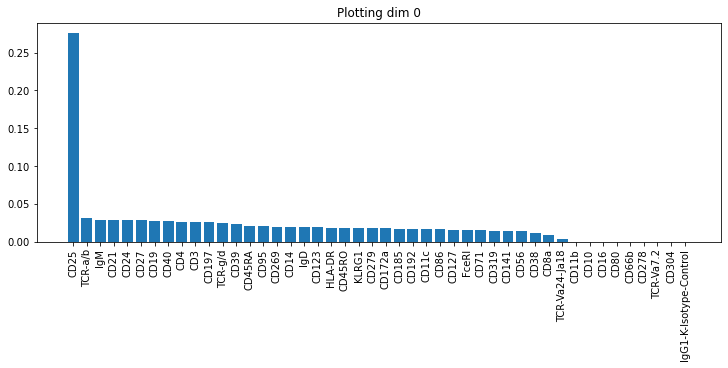

Top proteins: CD25, TCR-a/b, IgM, CD21, CD24, CD27, CD19, CD40, CD4


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


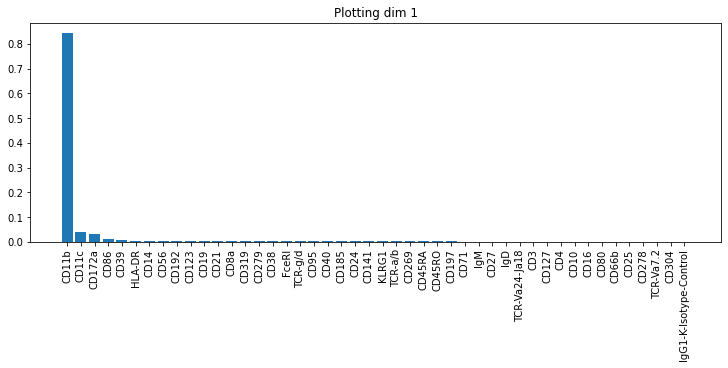

Top proteins: CD11b


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


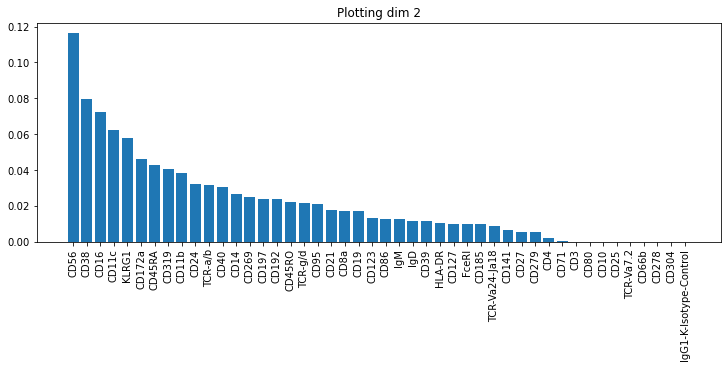

Top proteins: CD56, CD38, CD16, CD11c, KLRG1, CD172a, CD45RA, CD319


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


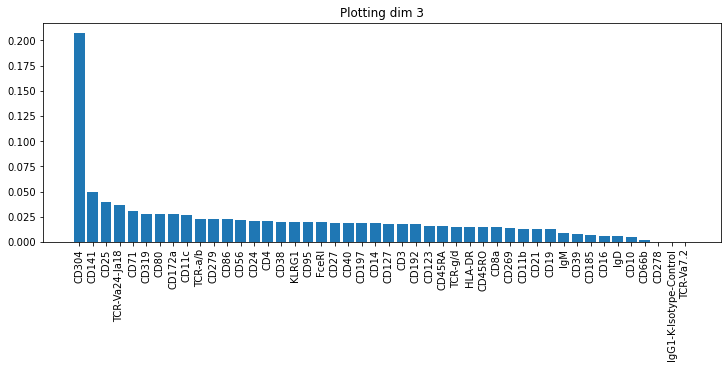

Top proteins: CD304, CD141, CD25, TCR-Va24-Ja18, CD71, CD319, CD80, CD172a, CD11c, TCR-a/b, CD279


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


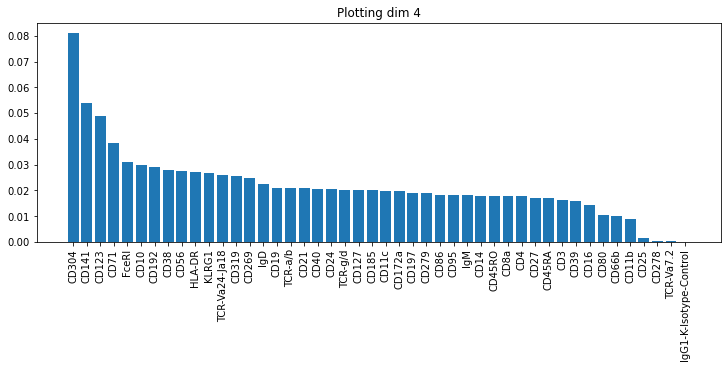

Top proteins: CD304, CD141, CD123, CD71, FceRI, CD10, CD192, CD38, CD56, HLA-DR, KLRG1, TCR-Va24-Ja18, CD319, CD269, IgD


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


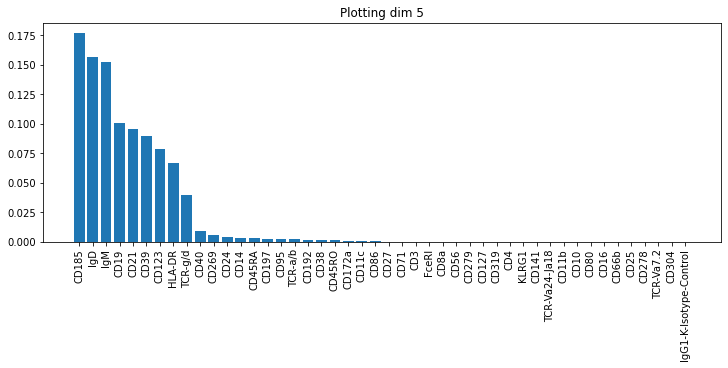

Top proteins: CD185, IgD, IgM, CD19


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


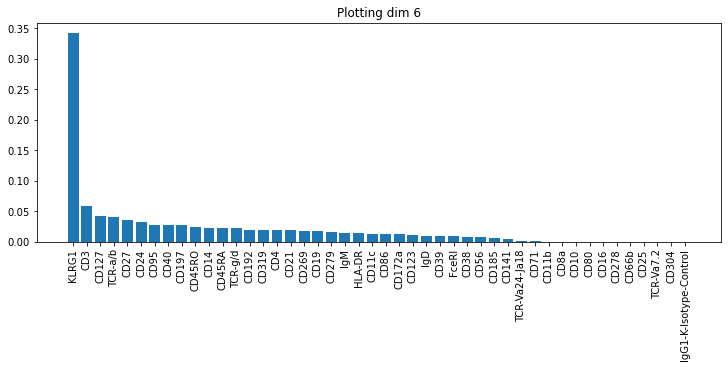

Top proteins: KLRG1, CD3, CD127, TCR-a/b, CD27


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


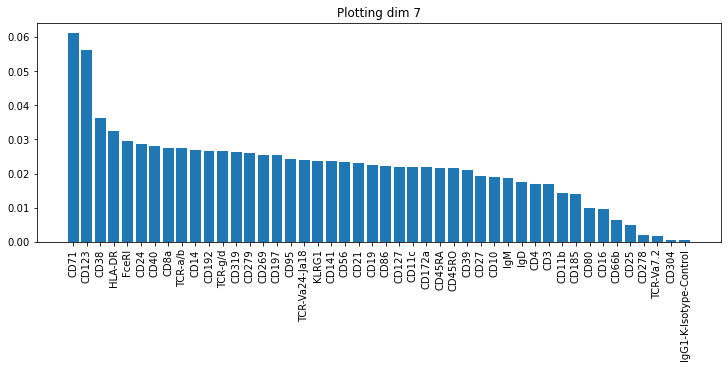

Top proteins: CD71, CD123, CD38, HLA-DR, FceRI, CD24, CD40, CD8a, TCR-a/b, CD14, CD192, TCR-g/d, CD319, CD279, CD269, CD197


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


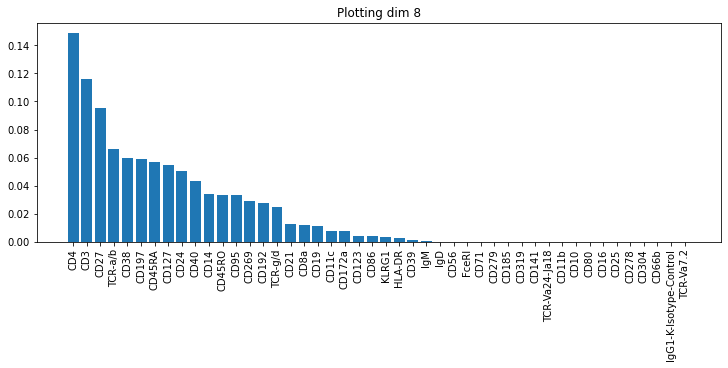

Top proteins: CD4, CD3, CD27, TCR-a/b, CD38, CD197


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


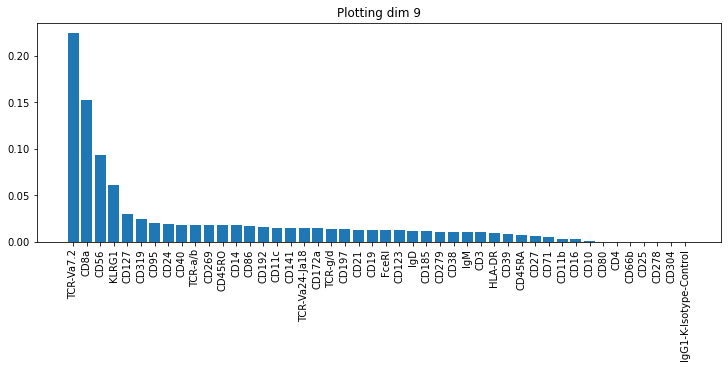

Top proteins: TCR-Va7.2, CD8a, CD56, KLRG1


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


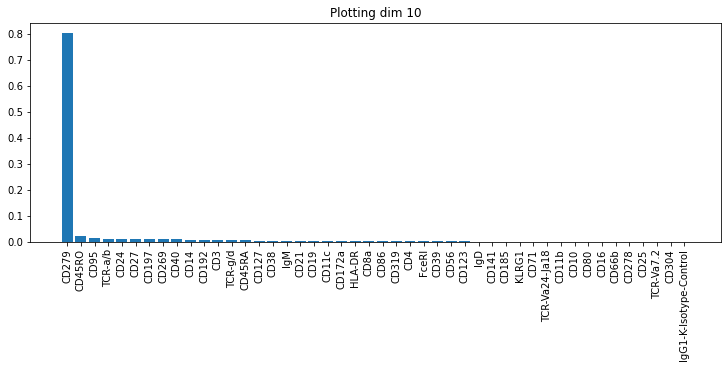

Top proteins: CD279


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


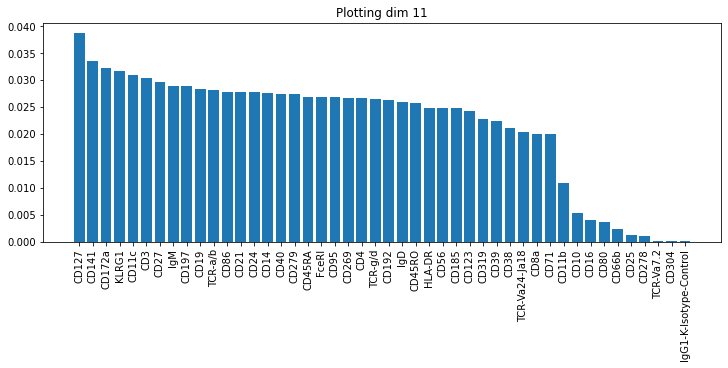

Top proteins: CD127, CD141, CD172a, KLRG1, CD11c, CD3, CD27, IgM, CD197, CD19, TCR-a/b, CD86, CD21, CD24, CD14, CD40, CD279


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


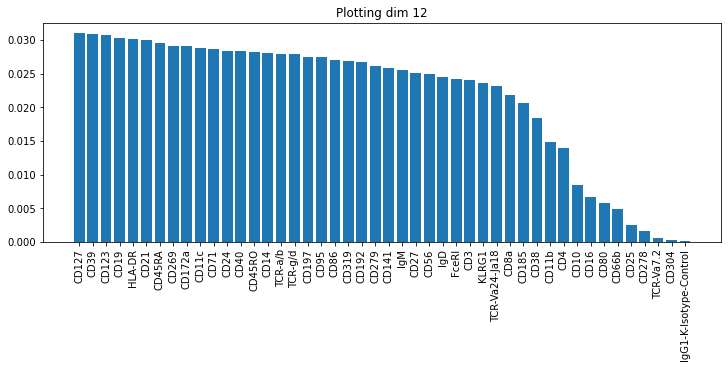

Top proteins: CD127, CD39, CD123, CD19, HLA-DR, CD21, CD45RA, CD269, CD172a, CD11c, CD71, CD24, CD40, CD45RO, CD14, TCR-a/b, TCR-g/d, CD197


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


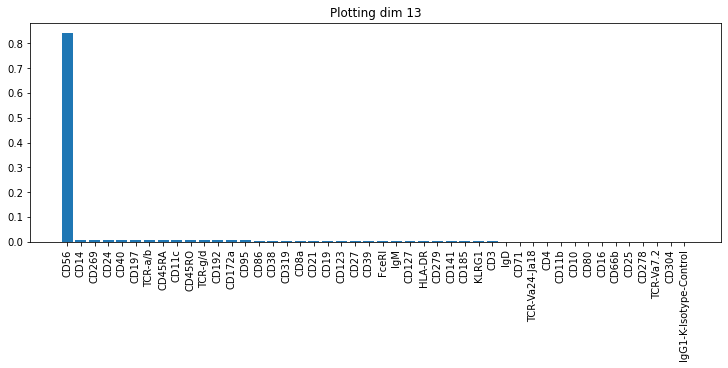

Top proteins: CD56


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


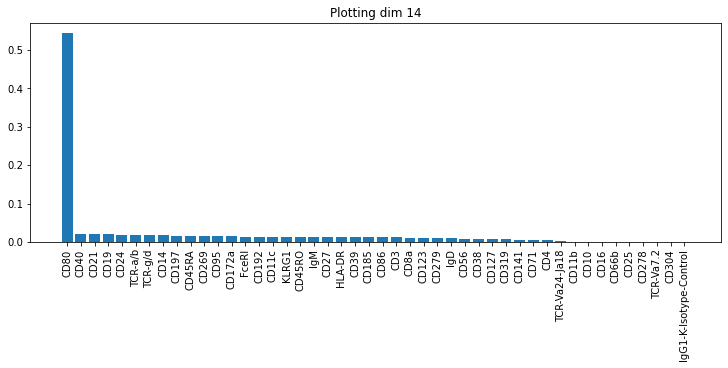

Top proteins: CD80


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


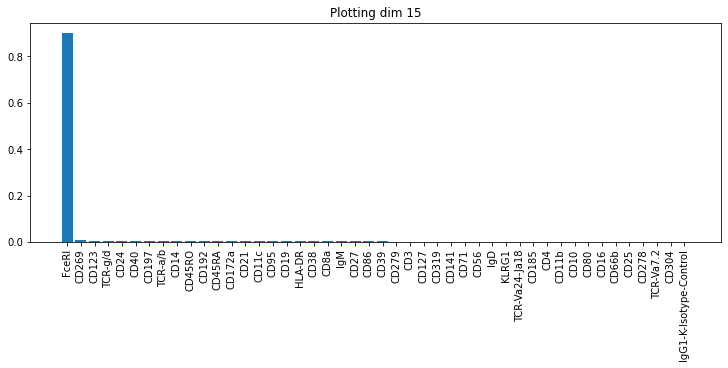

Top proteins: FceRI


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


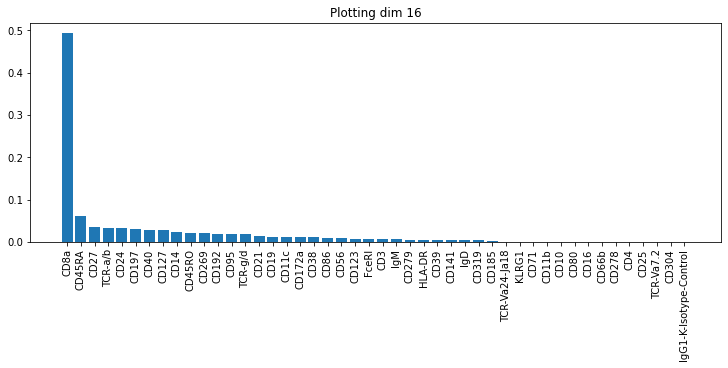

Top proteins: CD8a, CD45RA


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


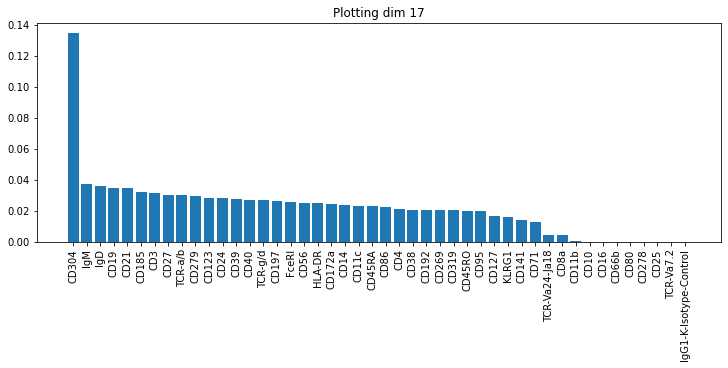

Top proteins: CD304, IgM, IgD, CD19, CD21, CD185, CD3, CD27, TCR-a/b, CD279, CD123, CD24, CD39


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


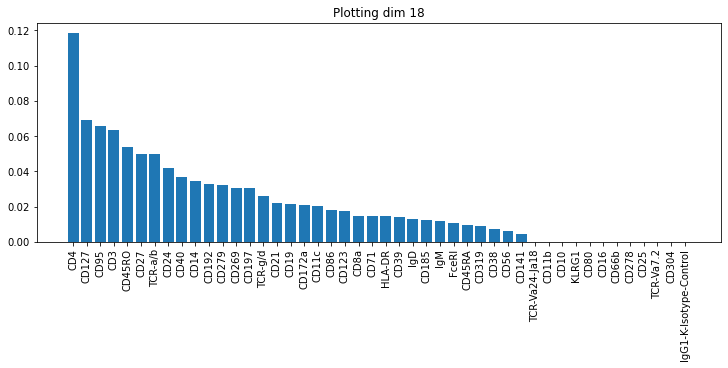

Top proteins: CD4, CD127, CD95, CD3, CD45RO, CD27, TCR-a/b, CD24


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


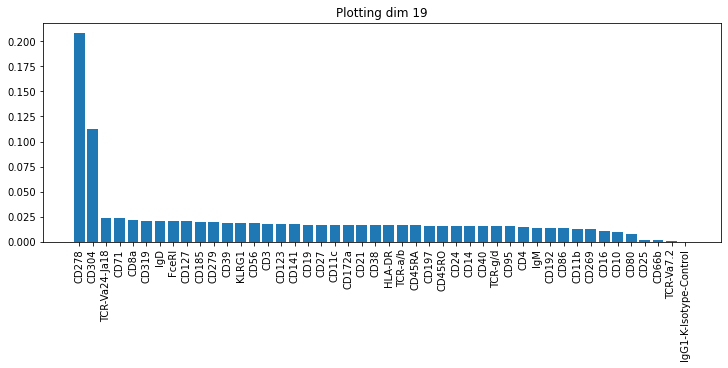

Top proteins: CD278, CD304, TCR-Va24-Ja18, CD71, CD8a, CD319, IgD, FceRI, CD127, CD185, CD279


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


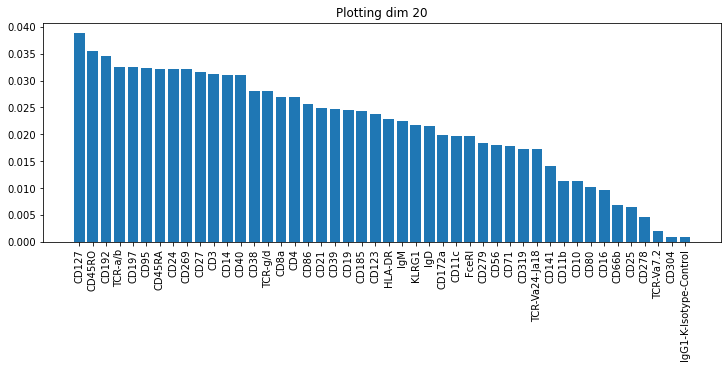

Top proteins: CD127, CD45RO, CD192, TCR-a/b, CD197, CD95, CD45RA, CD24, CD269, CD27, CD3, CD14, CD40, CD38, TCR-g/d, CD8a


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


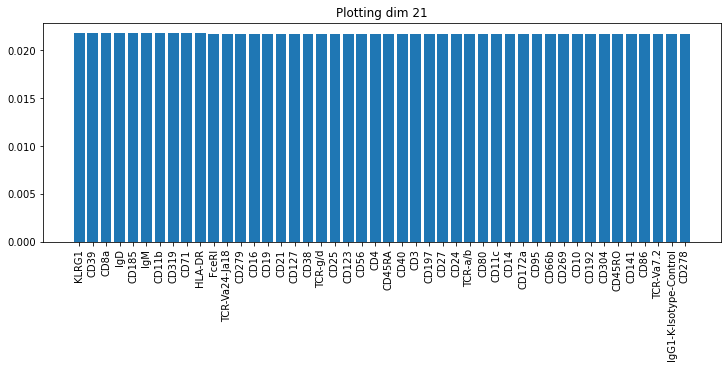

Top proteins: KLRG1, CD39, CD8a, IgD, CD185, IgM, CD11b, CD319, CD71, HLA-DR, FceRI, TCR-Va24-Ja18, CD279, CD16, CD19, CD21, CD127, CD38, TCR-g/d, CD25, CD123, CD56, CD4


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


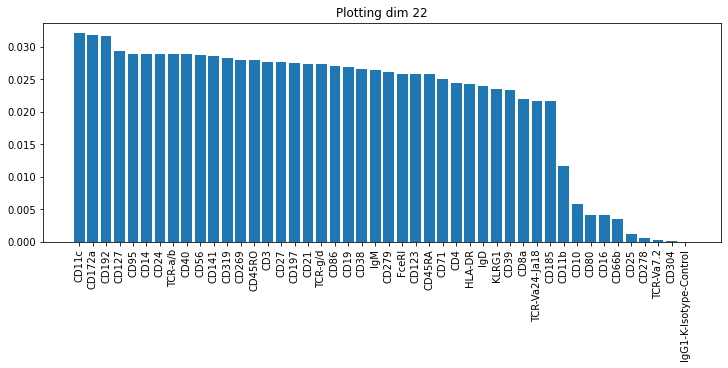

Top proteins: CD11c, CD172a, CD192, CD127, CD95, CD14, CD24, TCR-a/b, CD40, CD56, CD141, CD319, CD269, CD45RO, CD3, CD27, CD197, CD21


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


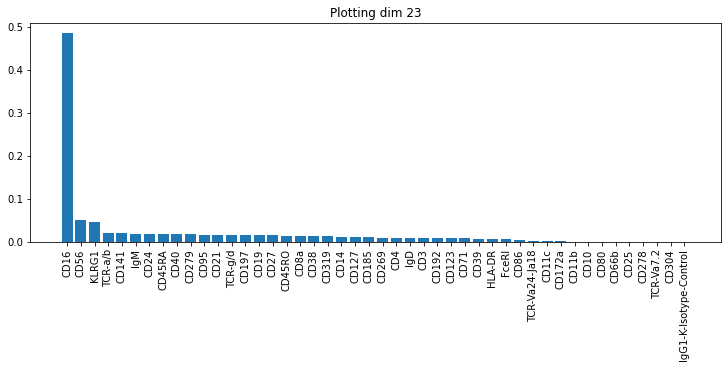

Top proteins: CD16, CD56


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


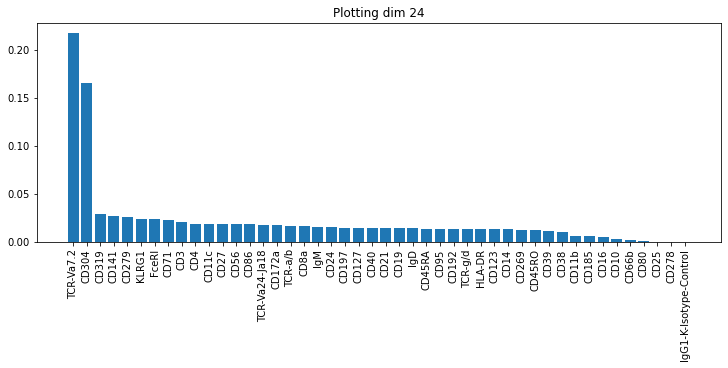

Top proteins: TCR-Va7.2, CD304, CD319, CD141, CD279, KLRG1, FceRI


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


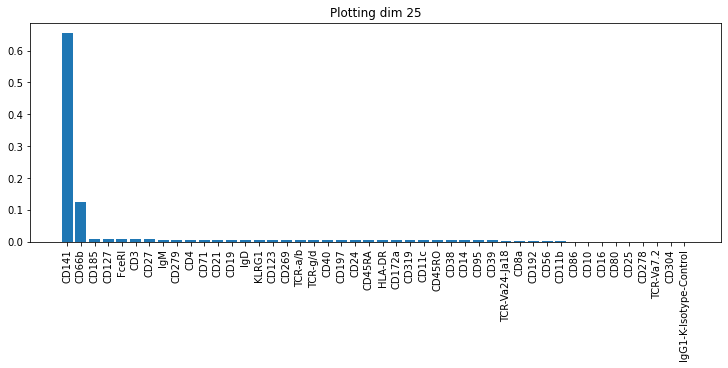

Top proteins: CD141


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


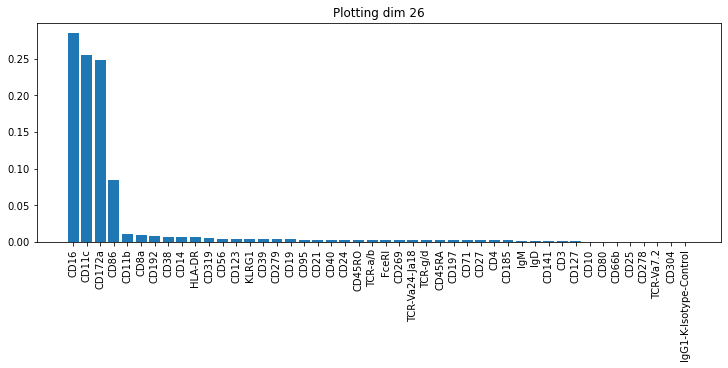

Top proteins: CD16, CD11c


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


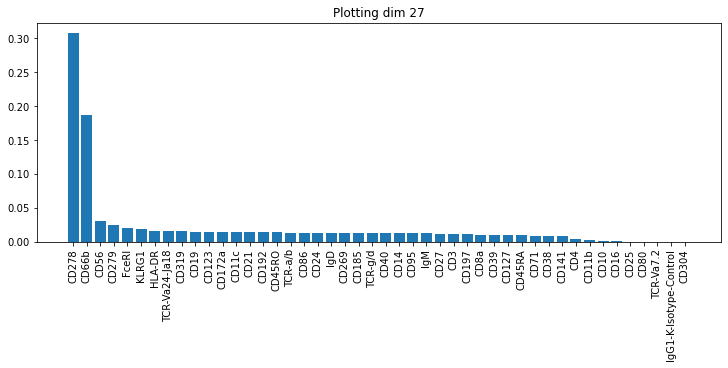

Top proteins: CD278, CD66b, CD56


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


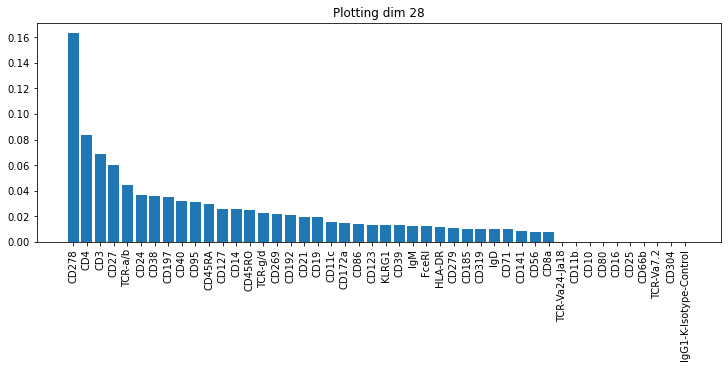

Top proteins: CD278, CD4, CD3, CD27, TCR-a/b, CD24, CD38, CD197


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


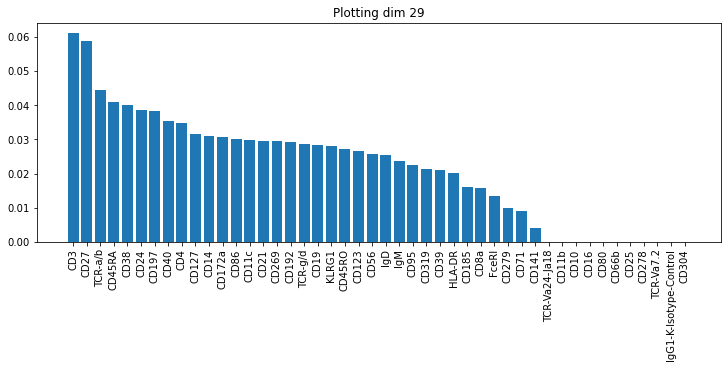

Top proteins: CD3, CD27, TCR-a/b, CD45RA, CD38, CD24, CD197, CD40, CD4, CD127, CD14, CD172a, CD86


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


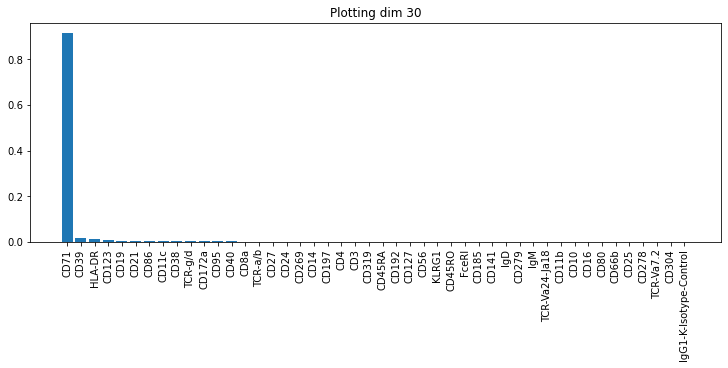

Top proteins: CD71


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


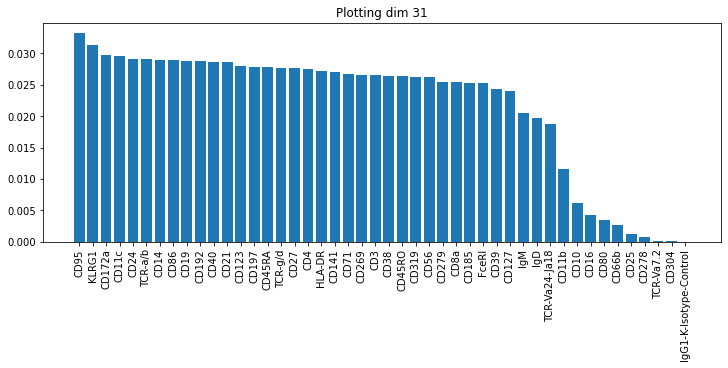

Top proteins: CD95, KLRG1, CD172a, CD11c, CD24, TCR-a/b, CD14, CD86, CD19, CD192, CD40, CD21, CD123, CD197, CD45RA, TCR-g/d, CD27, CD4


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


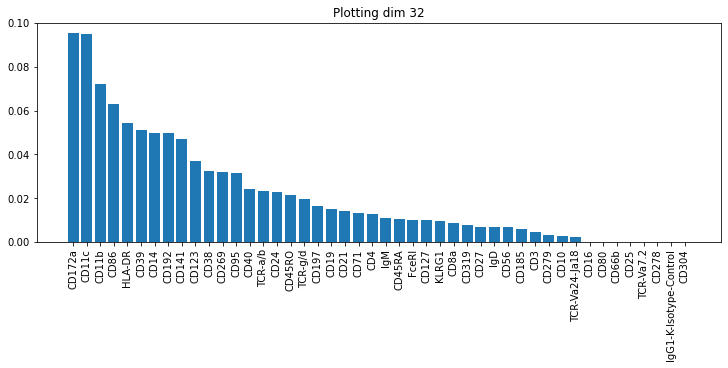

Top proteins: CD172a, CD11c, CD11b, CD86, HLA-DR, CD39, CD14, CD192


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


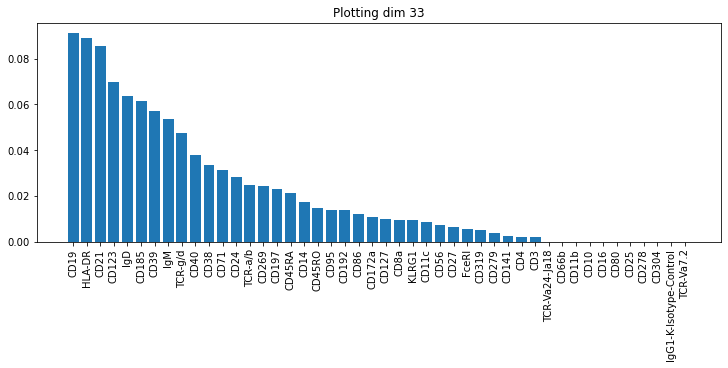

Top proteins: CD19, HLA-DR, CD21, CD123, IgD, CD185, CD39


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


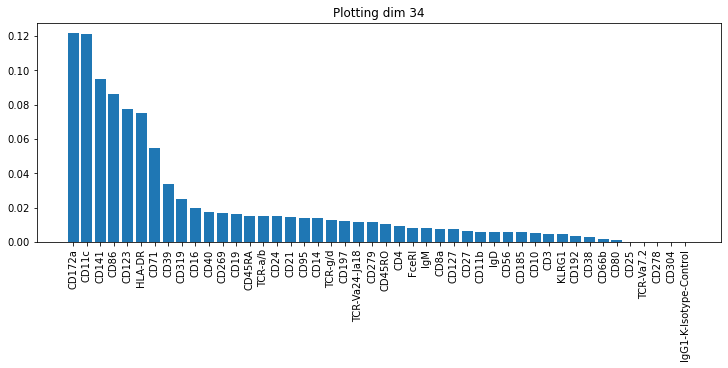

Top proteins: CD172a, CD11c, CD141, CD86, CD123


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


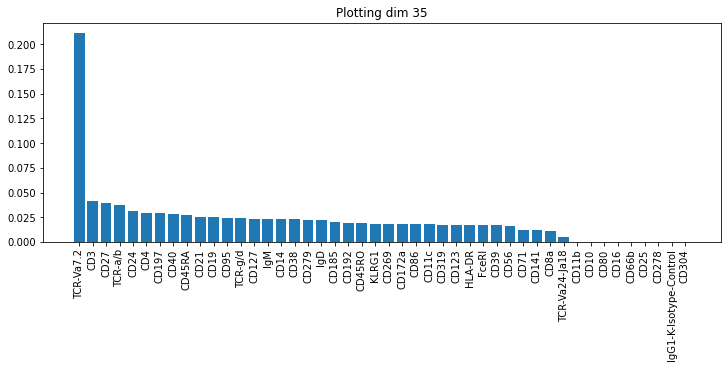

Top proteins: TCR-Va7.2, CD3, CD27, TCR-a/b, CD24, CD4, CD197, CD40, CD45RA, CD21, CD19


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


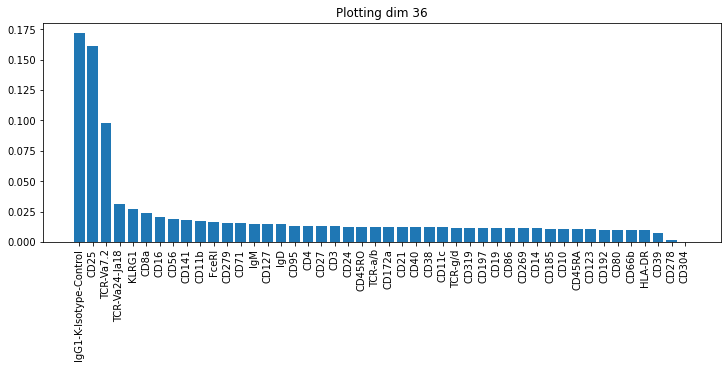

Top proteins: IgG1-K-Isotype-Control, CD25, TCR-Va7.2, TCR-Va24-Ja18, KLRG1, CD8a


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


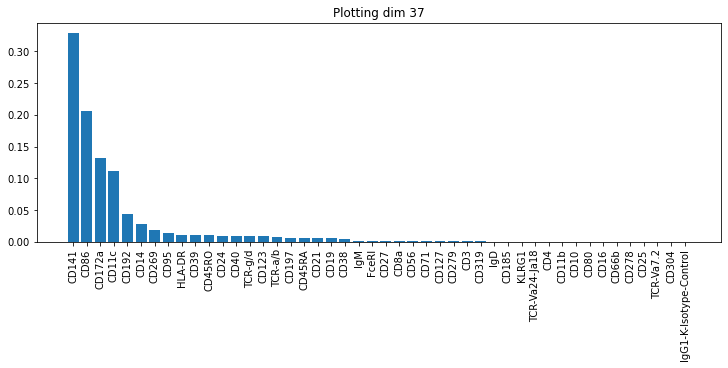

Top proteins: CD141, CD86


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


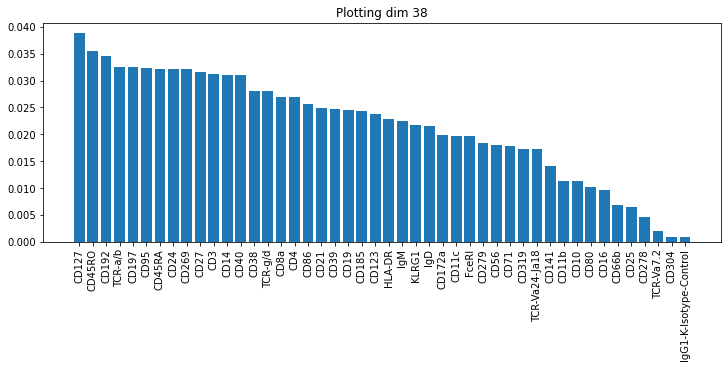

Top proteins: CD127, CD45RO, CD192, TCR-a/b, CD197, CD95, CD45RA, CD24, CD269, CD27, CD3, CD14, CD40, CD38, TCR-g/d, CD8a


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


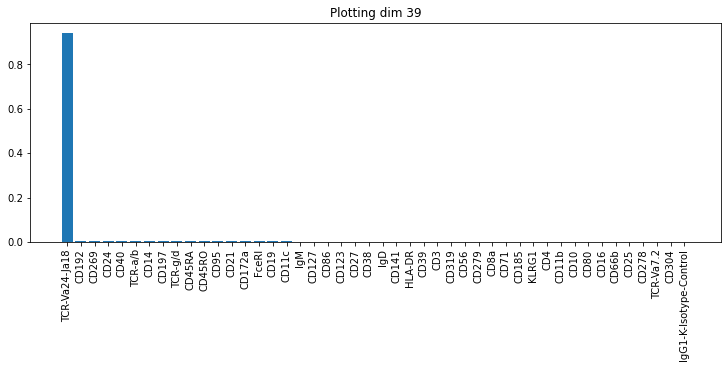

Top proteins: TCR-Va24-Ja18


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


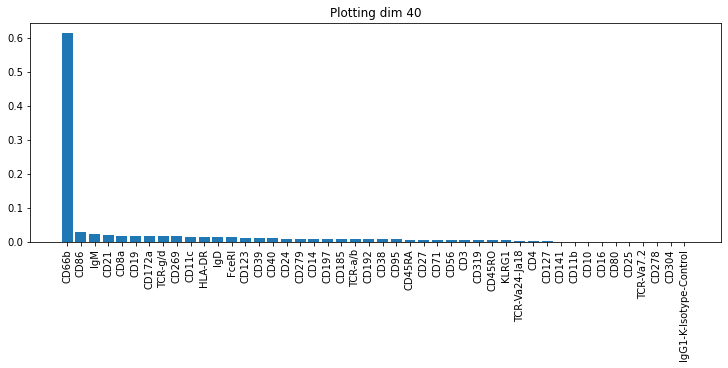

Top proteins: CD66b


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


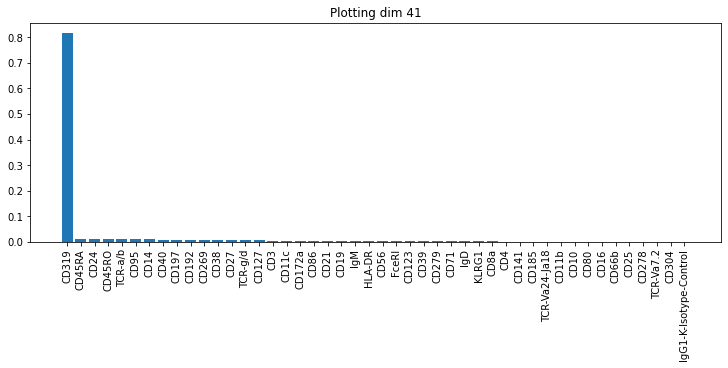

Top proteins: CD319


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


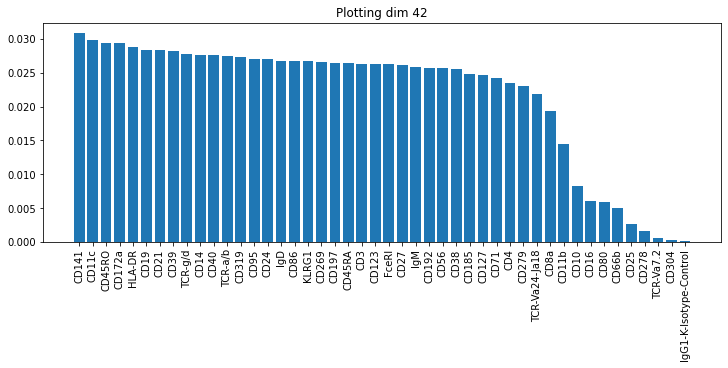

Top proteins: CD141, CD11c, CD45RO, CD172a, HLA-DR, CD19, CD21, CD39, TCR-g/d, CD14, CD40, TCR-a/b, CD319, CD95, CD24, IgD, CD86, KLRG1


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


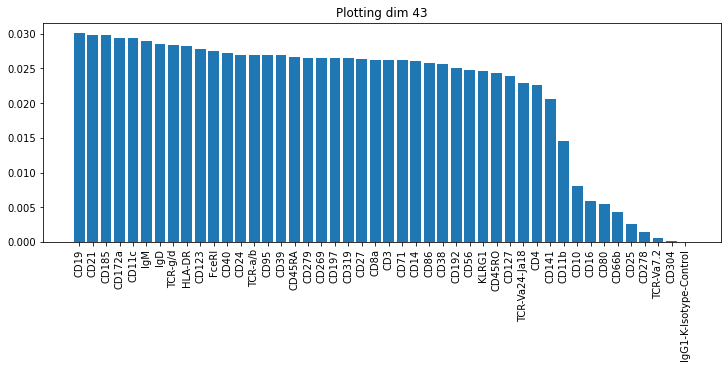

Top proteins: CD19, CD21, CD185, CD172a, CD11c, IgM, IgD, TCR-g/d, HLA-DR, CD123, FceRI, CD40, CD24, TCR-a/b, CD95, CD39, CD45RA, CD279


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


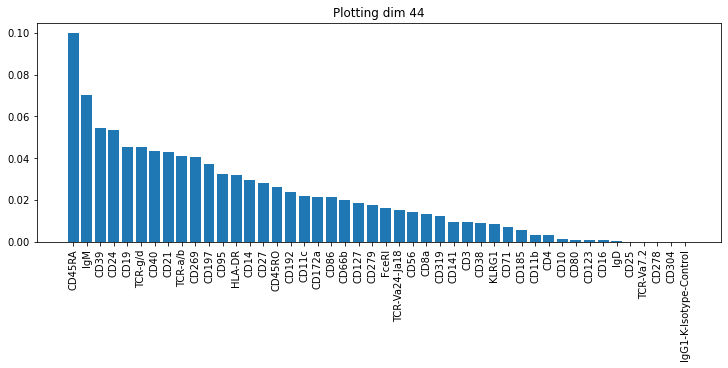

Top proteins: CD45RA, IgM, CD39, CD24, CD19, TCR-g/d, CD40, CD21, TCR-a/b, CD269


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


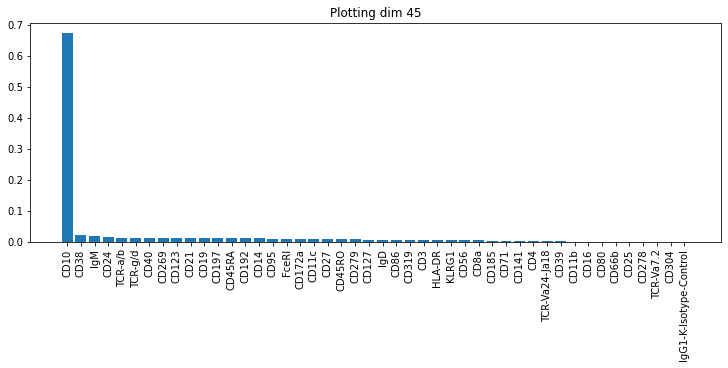

Top proteins: CD10


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


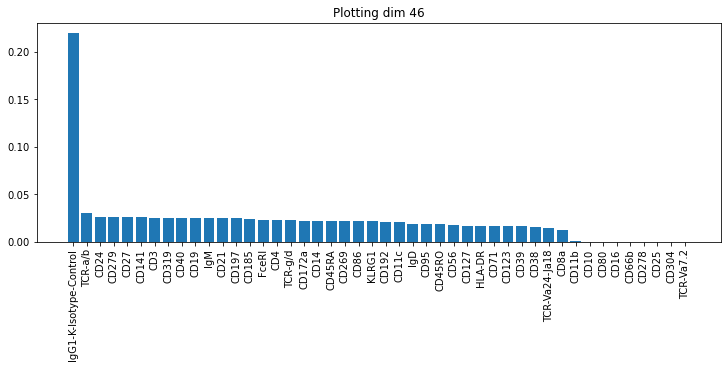

Top proteins: IgG1-K-Isotype-Control, TCR-a/b, CD24, CD279, CD27, CD141, CD3, CD319, CD40, CD19, IgM, CD21


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


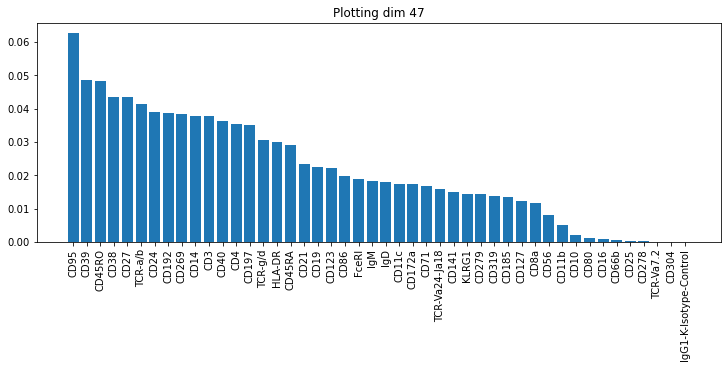

Top proteins: CD95, CD39, CD45RO, CD38, CD27, TCR-a/b, CD24, CD192, CD269, CD14, CD3, CD40


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


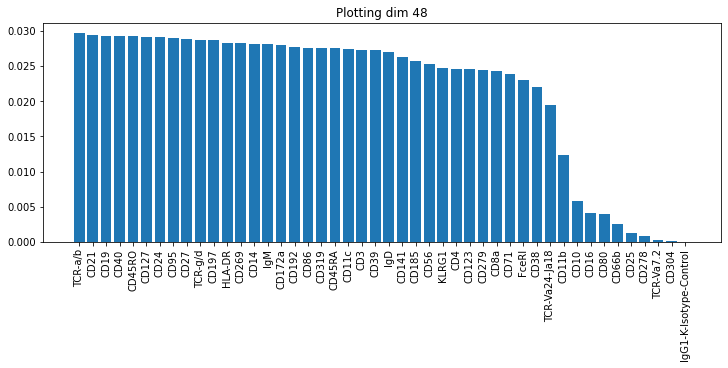

Top proteins: TCR-a/b, CD21, CD19, CD40, CD45RO, CD127, CD24, CD95, CD27, TCR-g/d, CD197, HLA-DR, CD269, CD14, IgM, CD172a, CD192, CD86


<ipython-input-18-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


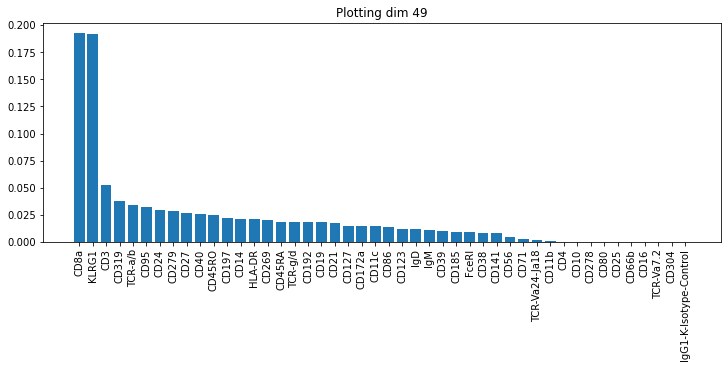

Top proteins: CD8a, KLRG1, CD3, CD319, TCR-a/b


In [19]:
for dim in range(50):
    plot_proteins(dim)
    print("Top proteins:", ", ".join(top_proteins(dim)))

<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


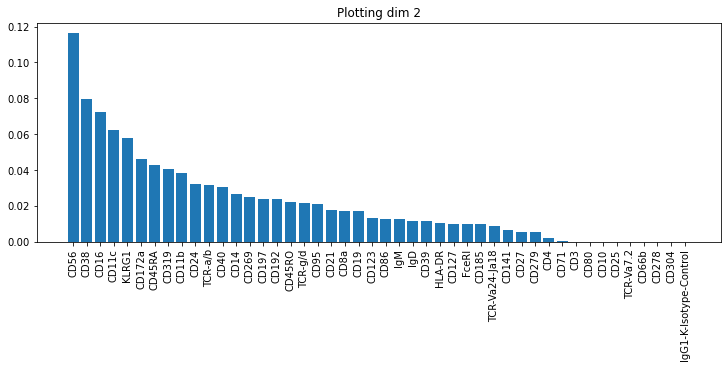

Top proteins: CD56, CD38, CD16, CD11c, KLRG1, CD172a, CD45RA, CD319
Top genes: GNLY, MCTP2, YES1, AOAH, PLCB1, ZEB2, RAP1GAP2, PTPN12, NCALD, BNC2
Top peaks: chr4:8408925-8410213, chr1:184386284-184389026, chr22:37161378-37165123, chr12:121557387-121558559, chr20:38872579-38876222, chr17:17662921-17664193, chr22:23263648-23264676, chr7:74092433-74095372, chr19:10796878-10798373, chr12:128794476-128798200


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


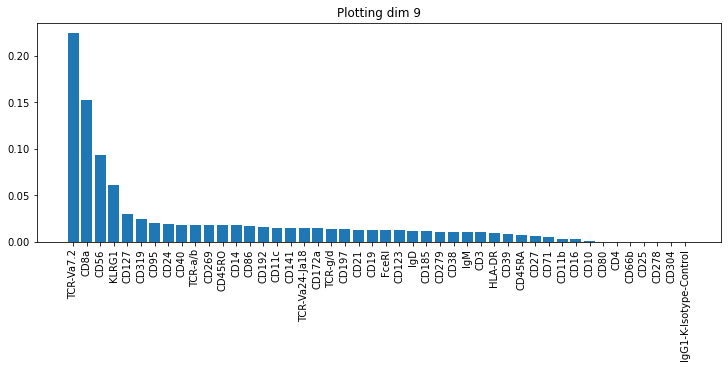

Top proteins: TCR-Va7.2, CD8a, CD56, KLRG1
Top genes: ZBTB16, DLEU1, PHACTR2, PLCB1, SLC4A10, RUNX2, MAN1A1, ERN1, SLC7A5, CYTH3
Top peaks: chr11:114073306-114076321, chr17:3794780-3797254, chr17:82909317-82910155, chr16:17590996-17592356, chr1:57307223-57307988, chr11:114065737-114066743, chr6:167112403-167115173, chr4:26131089-26132323, chr2:86785355-86787189, chr22:44709765-44711773


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


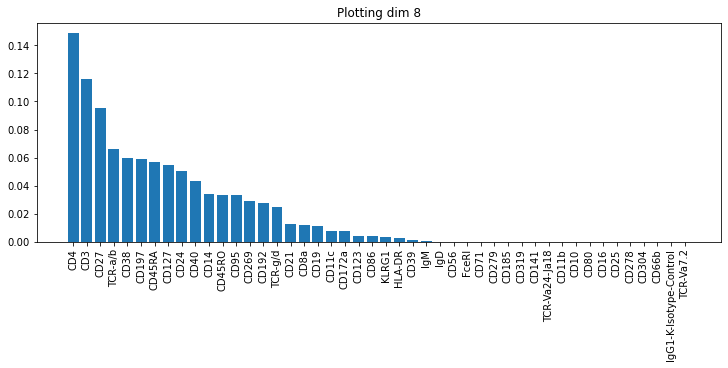

Top proteins: CD4, CD3, CD27, TCR-a/b, CD38, CD197
Top genes: MALAT1, MT-CO2, PRKCH, TSHZ2, BCL11B, MT-ND1, CD247, FHIT, BACH2, PDE3B
Top peaks: chr17:74176996-74177017, chr20:2901289-2901302, chr14:77039541-77041464, chr17:82126302-82128174, chr1:234723095-234725922, chr8:144684197-144688356, chr20:1224477-1227158, chr21:45589899-45592970, chr6:137823641-137825298, chr12:120011680-120015691


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


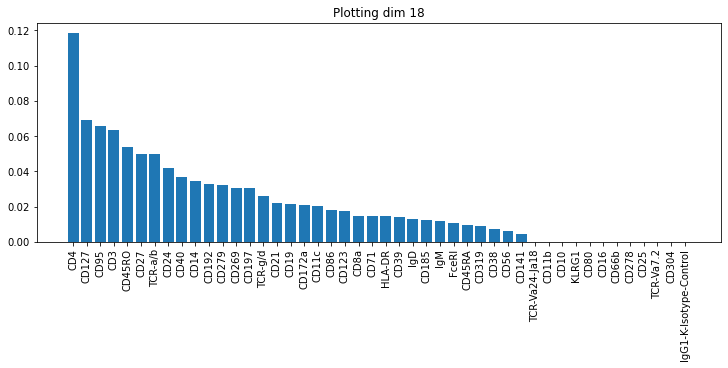

Top proteins: CD4, CD127, CD95, CD3, CD45RO, CD27, TCR-a/b, CD24
Top genes: LMNA, ITGB1, TNFAIP3, PBX4, SAMSN1, NIBAN1, LRIG1, GPRIN3, ANXA1, ANK3
Top peaks: chr12:120011680-120015691, chr9:131666728-131670626, chr1:15948613-15951748, chr20:48768708-48770140, chr22:39089958-39092703, chr17:80891138-80893450, chr9:129866220-129870482, chr15:69467852-69469524, chr3:46947073-46949750, chr16:79598234-79602765


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


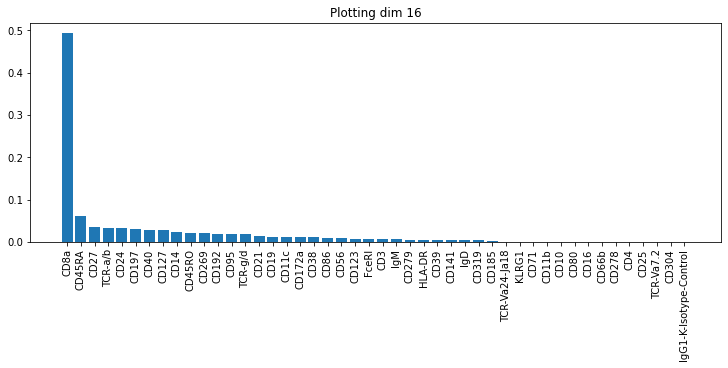

Top proteins: CD8a, CD45RA
Top genes: MALAT1, MT-CO2, MT-ND1, NELL2, PRKCH, PDE3B, BCL11B, BACH2, KLRK1, CAMK4
Top peaks: chr2:86785355-86787189, chr17:74176996-74177017, chr20:2901289-2901302, chr11:66315532-66318943, chr10:132158175-132162575, chr12:10721324-10723787, chr2:86807275-86809907, chr3:49553728-49555305, chr2:241034990-241037472, chr1:24963259-24967301


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


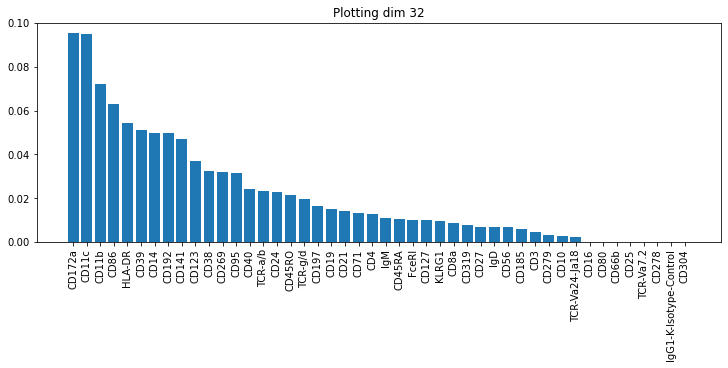

Top proteins: CD172a, CD11c, CD11b, CD86, HLA-DR, CD39, CD14, CD192
Top genes: JARID2, ZEB2, GAB2, ITGAX, RBM47, LRMDA, PTPRE, SLC11A1, ARHGAP26, PTK2B
Top peaks: chr17:74176996-74177017, chr20:2901289-2901302, chr20:40687498-40690954, chr15:70507511-70510172, chr3:46088920-46091418, chr12:54382824-54386099, chr4:7646534-7651079, chr17:74512290-74515467, chr7:151795424-151798297, chr7:101717093-101718814


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


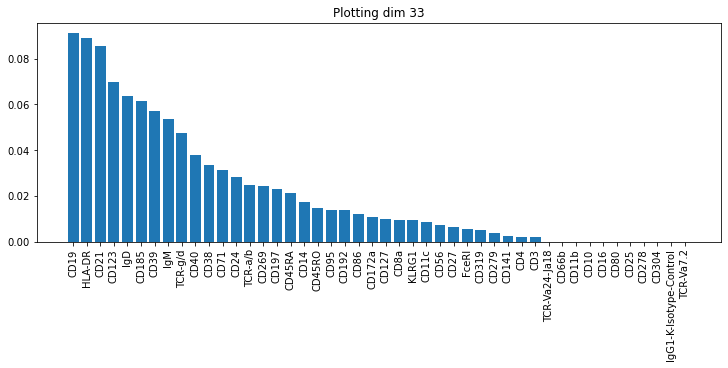

Top proteins: CD19, HLA-DR, CD21, CD123, IgD, CD185, CD39
Top genes: AFF3, BANK1, LYN, AUTS2, ARHGAP24, ADAM28, SIPA1L1, TRIO, COL19A1, GNG7
Top peaks: chr17:74176996-74177017, chr20:2901289-2901302, chr6:167112403-167115173, chr19:2677615-2682203, chr15:74382031-74386562, chr6:150598982-150601209, chr9:123337879-123341080, chr19:13102147-13105863, chr16:67527882-67532349, chr2:231670897-231673760


<ipython-input-16-814c84e6214a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


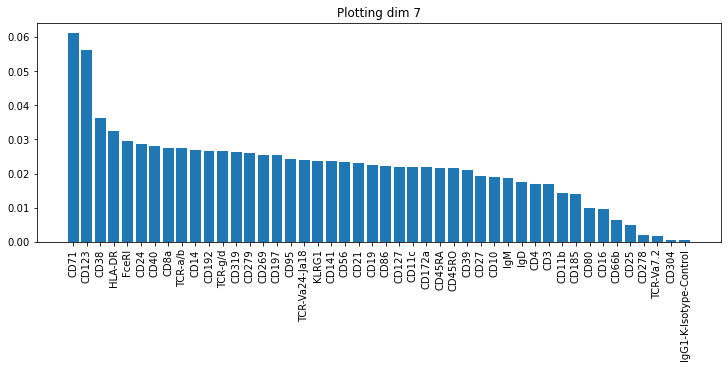

Top proteins: CD71, CD123, CD38, HLA-DR, FceRI, CD24, CD40, CD8a, TCR-a/b, CD14, CD192, TCR-g/d, CD319, CD279, CD269, CD197
Top genes: ATP8B4, CALN1, MED12L, MEIS1, RNF220, NKAIN2, CASC15, TAFA2, ZNF385D, MAML3
Top peaks: chr16:49281723-49282268, chr19:55165848-55167710, chr18:25349450-25352652, chr1:72282271-72284748, chr16:658971-661986, chr7:25862076-25863012, chr10:119028821-119031025, chr7:151050526-151051620, chr17:50917999-50920483, chr4:1791951-1795648


In [17]:
for dim in [2, 9, 8, 18, 16, 32, 33, 7]:
    plot_proteins(dim)
    print("Top proteins:", ", ".join(top_proteins(dim)))
    print("Top genes:", ", ".join(top_genes(dim)[:10]))
    print("Top peaks:", ", ".join(top_peaks(dim)[:10]))

## Enrich

In [18]:
import gget
import pyperclip

In [46]:
import gprofiler
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
enr = gp.profile(
    organism="hsapiens",
    query={f"dim {dim}": list(top_genes(dim, threshold=0)[:200]) for dim in range(50)},
    sources=["GO:BP"],
)
enr["minlogp"] = -np.log10(enr["p_value"])
enr["occurences"] = enr["native"].map(enr["native"].value_counts())

In [75]:
enr.head()

source      native                                 name       p_value  \
0  GO:BP  GO:0045321                 leukocyte activation  8.935475e-28   
1  GO:BP  GO:0048583   regulation of response to stimulus  2.491918e-27   
2  GO:BP  GO:0002682  regulation of immune system process  2.900328e-27   
3  GO:BP  GO:0046649                lymphocyte activation  1.089352e-26   
4  GO:BP  GO:0001775                      cell activation  1.396197e-26   

   significant                                        description  term_size  \
0         True  "A change in morphology and behavior of a leuk...        953   
1         True  "Any process that modulates the frequency, rat...       3895   
2         True  "Any process that modulates the frequency, rat...       1442   
3         True  "A change in morphology and behavior of a lymp...        794   
4         True  "A change in the morphology or behavior of a c...       1094   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0         185                 56                  21100   0.302703  0.058762   
1         185                104                  21100   0.562162  0.026701   
2         185                 66                  21100   0.356757  0.045770   
3         185                 51                  21100   0.275676  0.064232   
4         185                 58                  21100   0.313514  0.053016   

    query                   parents  
0  dim 49  [GO:0001775, GO:0002376]  
1  dim 49  [GO:0050789, GO:0050896]  
2  dim 49  [GO:0002376, GO:0050789]  
3  dim 49              [GO:0045321]  
4  dim 49              [GO:0009987]

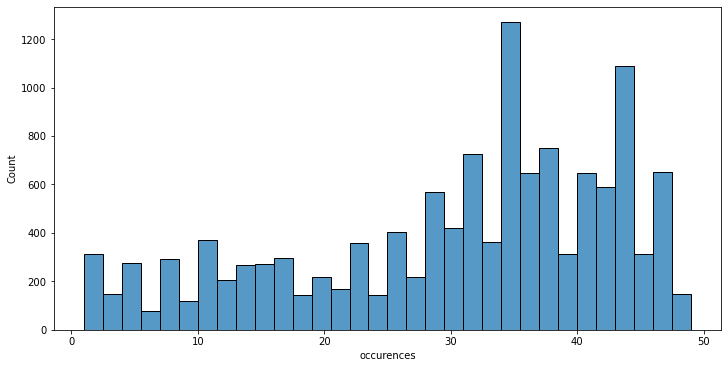

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
sns.histplot(data=enr, x="occurences", ax=ax)
plt.show()

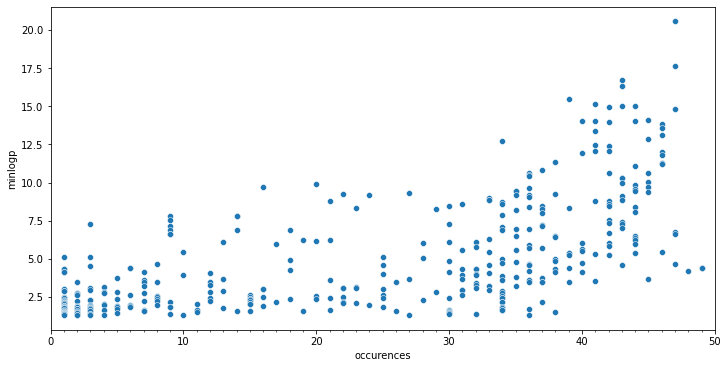

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
sns.scatterplot(data=enr[enr["query"] == "dim 32"], y="minlogp", x="occurences", ax=ax)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set(xlim=(0, 50))
plt.show()

In [426]:
pyperclip.copy("\t".join(mdata["rna"].var_names.str.replace("rna:", "")))

In [42]:
# pyperclip.copy("\n".join(top_genes(2, threshold=0)[:200])) # NK cells
# pyperclip.copy("\n".join(top_genes(9, threshold=0)[:200])) # MAIT T cells
# pyperclip.copy("\n".join(top_genes(8, threshold=0)[:200])) # CD4 T cells
# pyperclip.copy("\n".join(top_genes(18, threshold=0)[:200])) # CD4 T cells
# pyperclip.copy("\n".join(top_genes(16, threshold=0)[:200])) # CD8 T cells
# pyperclip.copy("\n".join(top_genes(32, threshold=0)[:200])) # Monocytes
# pyperclip.copy("\n".join(top_genes(33, threshold=0)[:200])) # B cells
# pyperclip.copy("\n".join(top_genes(7, threshold=0)[:200])) # Erythroid cells

In [419]:
def enrich(dim: int, database: str):
    idx = H["H_rna"][:, dim].argsort()[::-1]
    enr = gget.enrichr(top_genes(dim), database)
    enr["min_log_adj_p_val"] = -np.log10(enr["adj_p_val"])
    sns.scatterplot(data=enr.head(), x='min_log_adj_p_val', y='path_name', s=150)
    plt.show()

Mon Aug 29 16:44:32 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 16:44:32 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


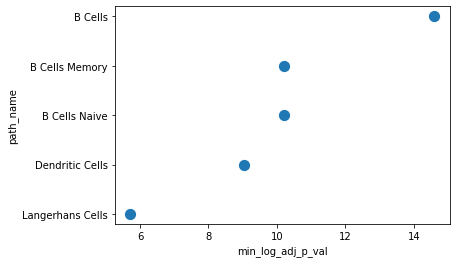

Mon Aug 29 16:44:33 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 16:44:33 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


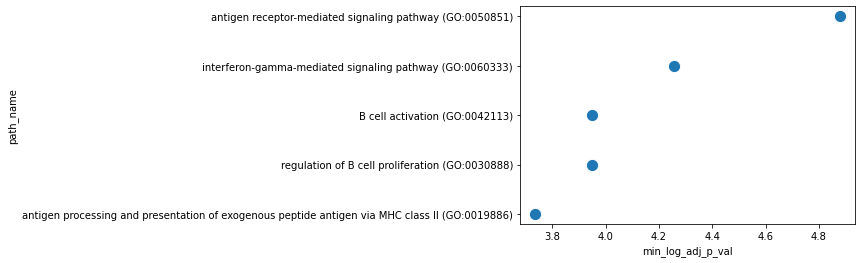

In [420]:
enrich(33, "celltypes")
enrich(33, "ontology")

## Motifs

In [406]:
H_rescaled = H["H_atac"] / H["H_atac"].sum(1).reshape(-1, 1)
for dim in range(50):
    idx = H_rescaled[:, dim].argsort()[::-1][:1_000]
    mdata["atac"].var["top_in_dim_" + str(dim)] = False
    mdata["atac"].var.loc[
        mdata["atac"].var_names[idx].to_numpy(dtype=str),
        "top_in_dim_" + str(dim),
    ] = True


In [407]:
mdata["atac"].var.to_csv('/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/top_var.csv')

In [107]:
# Run R

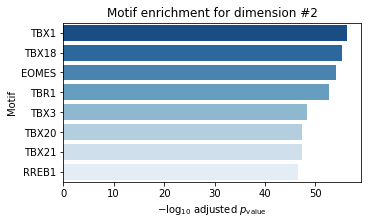

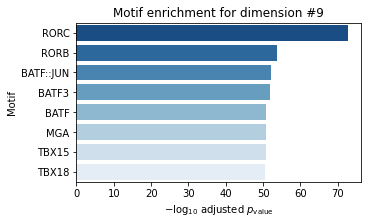

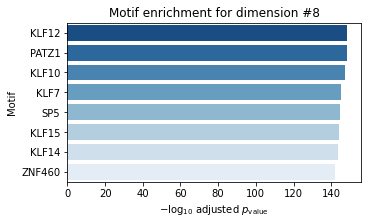

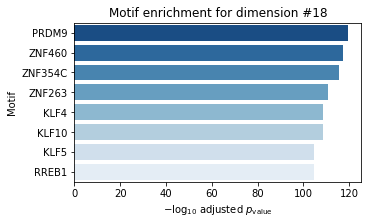

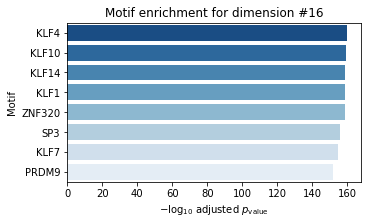

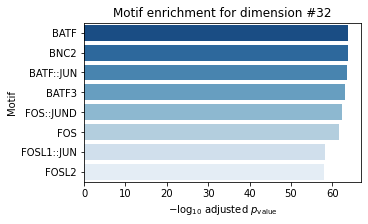

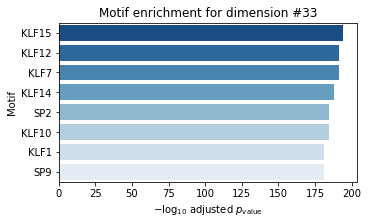

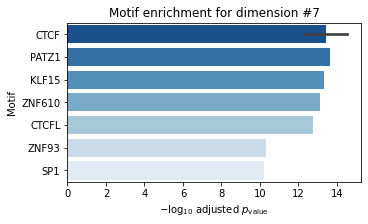

In [410]:
for dim in [2, 9, 8, 18, 16, 32, 33, 7]:

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

    motifs = pd.read_csv(
        f"/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/motifs/motifs_{dim}.csv",
        index_col=0,
    )
    motifs = motifs[motifs["motif"].str.startswith("MA")]
    motifs["minlogp.adjust"] = -np.log10(motifs["p.adjust"])
    sns.barplot(
        data=motifs[:8],
        x="minlogp.adjust",
        y="motif.name",
        ax=ax,
        palette="Blues_r",
    )
    ax.set_title(f"Motif enrichment for dimension #{dim}")
    ax.set_xlabel(r"$-\log_{10}~\mathrm{adjusted}~p_{\mathrm{value}}$")
    ax.set_ylabel("Motif")

    plt.show()
